<a href="https://colab.research.google.com/github/juancaalcaraz/practicaML/blob/main/BuenasPracticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Buenas prácticas para la evaluación de modelos y el ajuste de hiperparámetros.
## Pipelines.
### La clase pipelines de scikit-learn nos permite ajustar un modelo incluyendo un número arbitrario de pasos de transformación y aplicarlo para hacer predicciones sobre nuevos datos.
#### En esta ocación usaremos el dataset Breast Cancer Wisconsin.

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
# leyendo el dataset desde el sitio web de UCI.
# reading the dataset from the UCI website.
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

### Ahora las etiquetas de clase son 0 para un tumor benigno('B') y 1 para un tumor maligno('M'). Para comprobar este mapeo vamos a llamar a le.transform

In [3]:
le.transform(['M','B'])

array([1, 0])

In [4]:
# Dividimos el conjunto de datos en datos de enrenamiento y de prueba.
# We divide the data set into training and test data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=43)

### Vamos a estandarizar las columnas en el conjunto de datos breast cancer wisconsin antes de pasarlas a un clasificador lineal. Además vamos a suponer que queremos comprimir nuestros datos a partir de las 30 dimensiones iniciales en un subespacio bidimensional mediante un Análisis de componentes principales(ACP). En lugar de hacer estos pasos por separado, podemos encadenar estos objetos en un pipeline:

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
#pipeline para regresion logistica.
#pipeline for logistic regression.
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=43))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test precisión: %.3f' % pipe_lr.score(X_test, y_test))

Test precisión: 0.947


## Validación cruzada para evaluar el rendimiento de un modelo.
### La validación cruzada de k iteraciones es una técnica utilizada para evaluar el rendimiento de un modelo de aprendizaje automático. Consiste en dividir el conjunto de datos en k partes (llamadas pliegues), usar k-1 partes como conjunto de entrenamiento y la parte restante como conjunto de prueba en cada iteración. Esto se repite k veces, de manera que cada parte se utiliza una vez como conjunto de prueba. Al finalizar, se promedian los resultados de las k iteraciones para obtener una estimación más precisa del rendimiento del modelo. La validación cruzada de k iteraciones ayuda a reducir el sesgo en la evaluación del modelo y a obtener una estimación más robusta de su rendimiento.

In [6]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10)
print('CV puntuación de precisión: %s'% scores)

CV puntuación de precisión: [0.97826087 0.91304348 0.95652174 0.93478261 0.89130435 0.95555556
 0.97777778 1.         1.         0.97777778]


In [7]:
import numpy as np
print('Cv precisión: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Cv precisión: 0.959 +/- 0.034


## Diagnosticar problemas de sesgo y varianza con curvas de aprendizaje.
### Vamos a ver cómo podemos utilizar la funcion de curva de aprendizage de scikit-learn para evalual el modeo:

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear', penalty='l2', random_state=43))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10)

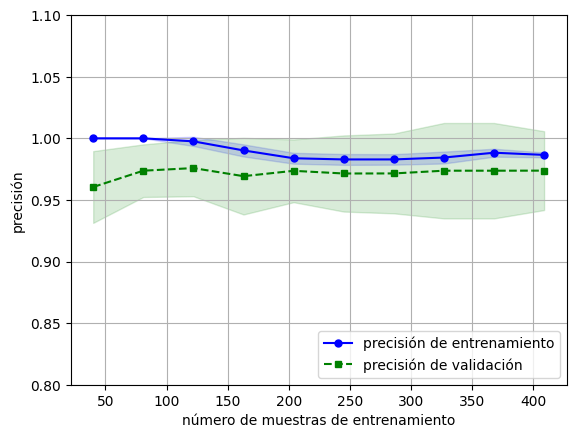

In [9]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o',
         markersize=5, label='precisión de entrenamiento')
#usamos fill_between para graficar la varianza de la estimacion.
#We use fill_between to plot the variance of the estimate.
plt.fill_between(train_sizes, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s',
         markersize=5, label='precisión de validación')

plt.fill_between(train_sizes, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('número de muestras de entrenamiento')
plt.ylabel('precisión')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.1])
plt.show()

### Como podemos ver en la curva de aprendizaje anterior, nuestro modelo funciona bien tanto para muestras de entrenamiento como para los de validacion si ha visto mas de 250 muestras, la precisión de entrenamiento y de validación es más separada para muestras menores a 200, siendo este un indicador de un grado de sobreajuste.   

## Resolver el sobreajuste y el subajuste con curvas de validación.

### Las curvas de validación son una herramienta útil para mejorar el rendimiento de un modelo solventando problemas como el sobreajuste o el subajuste. Con las curvas de validación modificamos los valores de los parámetros del modelo. Vamos a ahcer un ejemplo para el parámetro C de la regresón logística.  

In [10]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] #rango de parámetros.
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='logisticregression__C',
                                             param_range=param_range,
                                             cv=10)

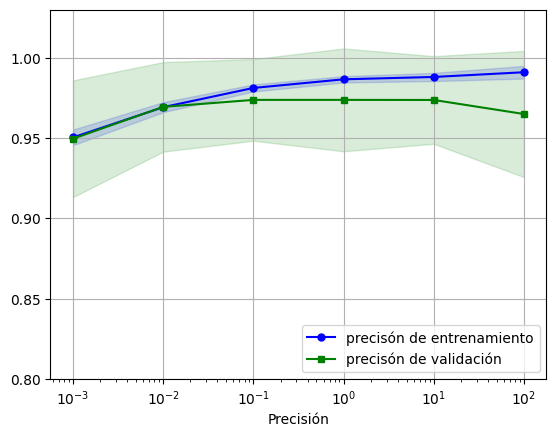

In [11]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean= np.mean(test_scores, axis=1)
test_std= np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o', markersize=5, label='precisón de entrenamiento')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15, color='blue')


plt.plot(param_range, test_mean,
         color='green', marker='s', markersize=5, label='precisón de validación')
plt.fill_between(param_range, test_mean + test_std,
                 test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Precisión')
plt.ylim([0.8, 1.03])
plt.show()

## Ajustar hiperparámetros con búsqueda de cuadriculas.
### El enfoque de búsqueda de cuadrículas es bastante simple; se trata de un paradigma de búsqueda exhaustiva de fuerza bruta donde especificamos una lista de valores para diferentes hiperparámetros y el ordenador evalúa el rendimiento del modelo para cada combinación de dichos valores.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=43))

param_range = [0.0001,0.001,0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [ {'svc__C':param_range,
               'svc__kernel':['linear']},
              {'svc__C': param_range,
               'svc__gamma':param_range,
               'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator= pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)


0.9781159420289856


In [13]:
print(gs.best_params_)

{'svc__C': 1.0, 'svc__kernel': 'linear'}


In [14]:
#Utilizamos el conjunto de datos de prueba
#para estimar el rendimiento
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('test de precisión: %.3f'% clf.score(X_test, y_test))

test de precisión: 0.982


## Selección de algoritmos con validación cruzada anidada.
### En la validación cruzada anidada tenemos un bucle de valicación cruzada de $k$ iteraciones externo para dividir los datos en iteraciones de prueba y de entrenamiento, y un bucle interior para seleccionar el modelo mediante la validación cruzada de $k$ iteraciones denro de la iteración de enrtenamiento.

In [15]:
from sklearn.model_selection import cross_val_score
gs = GridSearchCV(estimator= pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV Precisión: %3.f +/- %3.f'% (np.mean(scores), np.std(scores)))

CV Precisión:   1 +/-   0


### Podemos utilizar la validación cruzada anidada para comparar el rendimiento de varios clasificadores con el mismo conjunto de datos.

In [16]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=43),
                  param_grid=[{'max_depth':[1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)
score = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'CV precision: {np.mean(score)} +/- {np.std(score)}')

CV precision: 0.9318681318681319 +/- 0.02447368950694517


### Como la precisión de SVM resulto ser mayor que la del árbol de desición podemos pensar que podría ser la mejor desición para clasificar nuevos datos procedentes de la misma población de este conjunto de datos

## Observar diferentes métricas para la evalucion de rendimientos
### Hemos evaluado anteriormente nuestros modelos con la precisión, útil para cuantificar el rendimiento del modelo. Sin embargo, existen otras métricas para medir la relevancia de un modelo, como la exactitud, la exhaustividad y el valor F.


## Leer una matriz de confusión.
### Es una matriz que dispone el rendimiento de un algoritmo de aprendizaje, es una matriz cuadrada que informa del recuento de las predicciones de **Verdarero positivo(TP), Verdadero Negativo(TN), Falso positivo(FP) y Falso Negativo(FN)**  

In [17]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true= y_test, y_pred=y_pred)
print(confmat)

[[70  2]
 [ 3 39]]


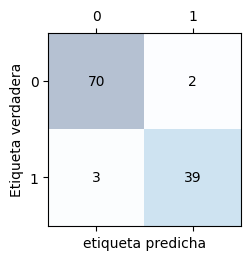

In [18]:
#Vamos a gráficar la matriz
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i,
            s=confmat[i, j],
            va='center', ha='center')
plt.xlabel('etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.show()
#La matriz representa.
# TN FP
# FN TP

### Con la representación de la matriz de confusión, notamos que nuestro modelo clasifica 70 muestras pertencientes a la clase 0 de forma correcta y 39 de la clase 1 de forma correcta, pero clasifico de forma erronea tres muestras de la clase 1 como de clase 0 y a predicho 2 muestras como 1 cuando es 0(Falso positivo).

## Optimizar la exactitud y la exhaustividad de un modelo de clasificación.
### Tanto la predicción **error(ERR)** como la **precisión(ACC)** proporcionan información general sobre los errores de clasicicación de algunas muestras. Podemos definir el error como la suma de todas las falsas predicciones divididas por el número de predicciones totales. Y la precisión se calcula como la suma de predicciones correctas dividida por el número total de predicciones.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
#Exactitud del modelo
print(f'Precisión: {precision_score(y_true=y_test, y_pred=y_pred)}')

Precisión: 0.9512195121951219


In [20]:
#recall sería exhaustividad
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_pred)}')

Recall: 0.9285714285714286


In [21]:
#F1 es una combinación entre exactitud(PRE) y exahaustividad(REC)
print(f'f1 Score: {f1_score(y_true=y_test, y_pred=y_pred)}')

f1 Score: 0.9397590361445782


### Además podemos utilizar una métrica disitinta a la precisión en GridSearch como se muestra a continuación:

In [22]:
from sklearn.metrics import make_scorer, f1_score
# Especificamos que la clase positiva es 0
# en lugar de 1 con make_scorer
scorer = make_scorer(f1_score, pos_label=0)
"""scorer = make_scorer(score_func= precision_score,
                     pos_label=1,
                     greater_is_better=True,
                     average='micro')
                     """
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs = gs.fit(X_train, y_train)

In [23]:
print(gs.best_score_)

0.9827575953325745


In [24]:
print(gs.best_params_)

{'svc__C': 1.0, 'svc__kernel': 'linear'}


## Representar una característica operatiava del receptor.
### Las representaciones gráficas ROC son útiles herramientas para seleccionar modelos para clasificación basados en su rendimiento respecto al FPR y al TPR, que se calculan desplazando el umbral de decisión del clasificador. La diagonal de un gráfico ROC se puede interpretar como adivinación aleatoria, y los modelos clasificados por debajo de esta diagonal se consideran peores que la adivinación aleatoria. Un clasificador perfecto debería caer en la esquina superior izquierda del gráfico con un TPR de 1 y un FPR de 0. También podemos calcular la denominada <<Aréa bajo la curva ROC>>(ROC AUC) para caracterizar el rendimiento de un modelo de clasificación.  

<ipython-input-25-f636909e6bf1>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-25-f636909e6bf1>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-25-f636909e6bf1>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


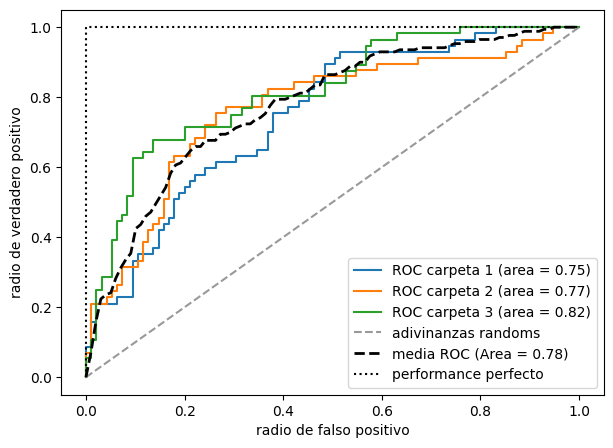

In [25]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold

pipe_lr= make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2', random_state=43, C=100.0))
X_train2 = X_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
  probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
  fpr, tpr, threshold = roc_curve(y_train[test],
                                  probas[:, 1],
                                  pos_label=1)
  mean_tpr += interp(mean_fpr, fpr, tpr)
  mean_tpr[0]= 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr,
           label='ROC carpeta %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='adivinanzas randoms')
mean_tpr /= len(cv)
mean_tpr[-1]= 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='media ROC (Area = %0.2f)'%mean_auc, lw=2)
plt.plot([0,0,1],
         [0,1,1],
         linestyle=':',
         color='black', label='performance perfecto')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('radio de falso positivo')
plt.ylabel('radio de verdadero positivo')
plt.legend(loc='lower right')
plt.show()

## Métricas de calificación para problemas multiclases
### Podemos utilizar métodos de micro y macro promedio para los problemas multiclase. El micropromedio es útil si queremos ponderar cada predicción equitativamente, mientras que el macropromedio pondera todas las clases igual para evaluar el rendimiento general de un clasificador con respecto a las etqiuetas de clase más frecuentes.
### Podemos especificar el método de promedio mediante el parámetro *average*:

In [26]:
from sklearn.metrics import make_scorer, precision_score
# Especificamos average='micro' como promedio de calificacion.
scorer = make_scorer(score_func= precision_score,
                     pos_label=1,
                     greater_is_better=True,
                     average='micro')
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

0.9781159420289856


## Tratar con el Desequilibrio de clases

### Para tratar con el desequilibrio de clases hay varios métodos. Uno sería configurar el parámetro *class_weight='balanced'* implementado en la mayoría de los clasificadores de scikit-learn, que asigna una penalización mayor a predicciones erróneas.
### Otras estrategias populares para el desequilibrio de clases incluyen el muestreo ascendente de la clase minoritaria, el muestreo descendente de la clase mayoritaria y la generación de muestras de entrenamiento sintéticas.
### La librería scikit-learn implementa la sencilla función *resample*, que puede ayudar al muestreo ascendente de la clase minoritaria dibujando nuevas muestras a partir del conjunto de datos y dibujará repetidamente nuevas muestras a partir del mismo hasta que contenga el mismo número de muestras que la etiqueta mayoritaria.   

In [37]:
from sklearn.utils import resample
print('numero de etiquetas de clase 1: ', X_train[y_train == 1].shape[0])

numero de etiquetas de clase 1:  170


In [38]:
print('numero de etiquetas de clase 0: ', X_train[y_train == 0].shape[0])

numero de etiquetas de clase 0:  285


In [40]:
X_upsamnple, y_upsample = resample(X_train[y_train==1], y_train[y_train==1], replace=True, n_samples=X_train[y_train == 0].shape[0], random_state=43)

In [41]:
print('numero de etiquetas de clase 1: ', X_upsamnple.shape[0])

numero de etiquetas de clase 1:  285


### Despúes del remuestreo, podemos combinar las muestras de la clase 0 original con el subconjunto de la clase 1 con muestreo ascendente para obtener un conjunto de datos equilibrado.